In [ ]:
!python -m spacy download en_core_web_lg
!pip install pylatexenc
!pip install xformers

In [ ]:
import spacy
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
from spacy.tokens import Doc
import networkx as nx
from typing import List, Dict, Tuple
from itertools import combinations
from sklearn.preprocessing import normalize
from scipy.optimize import linear_sum_assignment
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from pylatexenc.latex2text import LatexNodes2Text

In [ ]:
nlp = spacy.load('en_core_web_lg')
sentence_model = SentenceTransformer("dunzhang/stella_en_400M_v5",
                                     trust_remote_code=True)
#sentence_model = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5',
#                                     trust_remote_code=True)

In [ ]:
def normalize_text(text: str) -> str:
    text = LatexNodes2Text().latex_to_text(text)
    # ''.join(char.lower() for char in text if char.isalnum() or char.isspace())
    return re.sub(r"\s+", " ", text)


def create_graph(doc: Doc) -> nx.Graph:
    G = nx.Graph()
    #content_tokens = [token for token in doc if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'PROPN'] ]
    content_tokens = [token for token in doc ]
    if not content_tokens:
         return G

    words = [token.text for token in content_tokens]
    positions = [token.i for token in content_tokens]

    for i, (word, pos) in enumerate(zip(words, positions)):
        node_id = f"{word}_{pos}"
        G.add_node(node_id, word=word, pos=content_tokens[i].pos_,
                   vector = sentence_model.encode(word).tolist())

    distances = np.abs(np.subtract.outer(positions, positions))
    close_pairs = np.where((distances>0) & (distances<5))

    vectors = np.array( [G.nodes[ f"{words[i]}_{positions[i]}" ]["vector"]
                         for i in range(len(words)) ]  )
    similarities = np.dot(vectors, vectors.T)[close_pairs]

    for (i, j), similarity in zip(zip(*close_pairs), similarities):
        G.add_edge(f"{words[i]}_{positions[i]}",
                   f"{words[j]}_{positions[j]}",
                   weight=float(similarity))
    return G


def extract_subgraph(G: nx.Graph, query_words: List[str], n: int = 2)->nx.Graph:
    normalized_query_words = [normalize_text(word) for word in query_words]
    query_nodes = [node for node in G.nodes if G.nodes[node]['word'] in
                   normalized_query_words]
    subgraph_nodes = set(query_nodes)
    for node in query_nodes:
        subgraph_nodes.update(nx.ego_graph(G, node, radius=n))
    return G.subgraph(subgraph_nodes)


def semantic_wl_kernel(G1: nx.Graph, G2: nx.Graph, iterations: int = 3) -> float:
    def semantic_hash(label, neighbor_labels):
        return np.mean([label] + neighbor_labels, axis=0)

    def initialize_labels(G):
        return {node: np.array(G.nodes[node]['vector']) for node in G.nodes()}

    def wl_step(G, labels):
        new_labels = {}
        for node in G.nodes():
            neighbor_labels = [labels[nbr] for nbr in G.neighbors(node)]
            new_labels[node] = semantic_hash(labels[node], neighbor_labels)
        return new_labels

    labels1 = initialize_labels(G1)
    labels2 = initialize_labels(G2)

    histogram1 = Counter()
    histogram2 = Counter()

    for _ in range(iterations):
        for node, label in labels1.items():
            histogram1[hash(label.tobytes())] += 1
        for node, label in labels2.items():
            histogram2[hash(label.tobytes())] += 1

        labels1 = wl_step(G1, labels1)
        labels2 = wl_step(G2, labels2)

    all_hashes = set(histogram1.keys()) | set(histogram2.keys())
    similarity = sum( min(histogram1[h], histogram2[h]) for h in all_hashes )
    normalization = max(sum(histogram1.values()), sum(histogram2.values()))

    return similarity / normalization if normalization > 0 else 0


def node_embedding_similarity(G1: nx.Graph, G2: nx.Graph) -> float:
    embeddings1 = np.array([G1.nodes[node]['vector'] for node in G1.nodes()])
    embeddings2 = np.array([G2.nodes[node]['vector'] for node in G2.nodes()])

    if embeddings1.size == 0 or embeddings2.size == 0:
        return 0

    cost_matrix = 1 - np.dot(embeddings1, embeddings2.T) / (
        np.linalg.norm(embeddings1, axis=1)[:, np.newaxis] *
        np.linalg.norm(embeddings2, axis=1)
    )
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return 1 - cost_matrix[row_ind, col_ind].mean()


def spectral_similarity(G1: nx.Graph, G2: nx.Graph) -> float:
    L1 = nx.normalized_laplacian_matrix(G1).todense()
    L2 = nx.normalized_laplacian_matrix(G2).todense()
    eig1 = np.linalg.eigvals(L1)
    eig2 = np.linalg.eigvals(L2)
    max_len = max(len(eig1), len(eig2))
    eig1 = np.pad(eig1, (0, max_len - len(eig1)))
    eig2 = np.pad(eig2, (0, max_len - len(eig2)))
    return 1 / (1 + np.linalg.norm(eig1 - eig2))


def efficient_ged_similarity(G1: nx.Graph, G2: nx.Graph) -> float:

    def node_similarity(n1, n2):
        vec1 = np.array(G1.nodes[n1]['vector'])
        vec2 = np.array(G2.nodes[n2]['vector'])
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    cost_matrix = [[1 - node_similarity(n1,n2) for n2 in G2.nodes()] for n1 in G1.nodes()]
    cost_matrix = np.array(cost_matrix)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    node_subst_cost = sum(cost_matrix[row_ind,col_ind])
    edge_diff = abs(G1.number_of_edges()- G2.number_of_edges())
    total_cost = node_subst_cost + edge_diff
    max_cost = max(len(G1) + G1.number_of_edges(), len(G2) + G2.number_of_edges())
    return 1 - (total_cost / max_cost) if max_cost > 0 else 0


def compute_graph_similarity(G1: nx.Graph, G2: nx.Graph) -> float:
    wl_sim = semantic_wl_kernel(G1, G2)
    node_sim = node_embedding_similarity(G1, G2)
    spectral_sim = spectral_similarity(G1, G2)
    ged_sim = efficient_ged_similarity(G1, G2)
    #print(f"wl_sim: {wl_sim:.4f} node_sim: {node_sim:.4f} spectral_sim: {spectral_sim:.4f} ged_sim: {ged_sim:.4f}")
    wl_sim_correction = 4
    combined_sim = 0.4 * wl_sim * wl_sim_correction + 0.1 * node_sim + 0.1 * spectral_sim + 0.4 * ged_sim
    return combined_sim


def rank_documents(query: str, documents: List[str]) -> List[Tuple[str, float]]:
    query_doc = nlp(normalize_text(query))
    query_graph = create_graph(query_doc)
    query_words = [token.text for token in query_doc if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'PROPN']]
    ranked_docs = []
    for doc in tqdm(documents, total=len(documents)):
        try:
            doc_nlp = nlp(normalize_text(doc))
            doc_graph = create_graph(doc_nlp)
            doc_subgraph = extract_subgraph(doc_graph, query_words)
            if len(query_graph) == 0 or len(doc_subgraph) == 0:
                similarity = 0
            else:
                similarity = compute_graph_similarity(query_graph, doc_subgraph)
            ranked_docs.append((doc, similarity))
        except Exception as e:
            print(f"Error processing document: {doc}")
            print(f"Error message: {str(e)}")
            import traceback
            traceback.print_exc()
            ranked_docs.append((doc, 0))
    return sorted(ranked_docs, key=lambda x: x[1], reverse=True)

In [ ]:
query = "Cat sit on the tree"
documents = ["cat sit in car", "cat sleeping in house",
             "cat catching the mouse", "cat sleeping on table"]

ranked_docs = rank_documents(query, documents)
for doc, score in ranked_docs:
    print(f"{doc}: {score}")

wl_sim: 0.1333 node_sim: 0.8465 spectral_sim: 0.4449 ged_sim: 0.6924
cat sit in car: 0.6194338758185892
cat sleeping in house: 0
cat catching the mouse: 0
cat sleeping on table: 0


In [ ]:
mis = pd.read_csv('misconception_mapping.csv')
print(len(mis))
train = pd.read_csv('train.csv')
print(len(train))
test = pd.read_csv('test.csv')
print(len(test))
sub = pd.read_csv('sample_submission.csv')

2587
1869
3


In [ ]:
train.MisconceptionAId.value_counts()

,count
MisconceptionAId,
1214.0,18
1880.0,12
1379.0,11
1507.0,10
1990.0,10
...,...
1731.0,1
1788.0,1
1818.0,1


In [ ]:
train.MisconceptionDId.value_counts()

,count
MisconceptionDId,
1214.0,14
1379.0,8
113.0,8
1880.0,8
2392.0,7
...,...
931.0,1
1181.0,1
376.0,1


In [ ]:
question = train.QuestionText.values[0]
print(question)

construct = train.ConstructName.values[0]
print(construct)

\[
3 \times 2+4-5
\]
Where do the brackets need to go to make the answer equal \( 13 \) ?
Use the order of operations to carry out calculations involving powers


In [ ]:
train.ConstructId.value_counts()

,count
ConstructId,
473,14
1470,13
1428,13
854,12
3346,12
...,...
571,1
1477,1
1677,1


In [ ]:
task = train.QuestionText.values[0]
task

'\\[\n3 \\times 2+4-5\n\\]\nWhere do the brackets need to go to make the answer equal \\( 13 \\) ?'

In [ ]:
print(normalize_text(task))

 3 × 2+4-5 Where do the brackets need to go to make the answer equal 13 ?


In [ ]:
task = train.QuestionText.values[0]
task_doc = nlp(normalize_text(task))
task_graph = create_graph(task_doc)

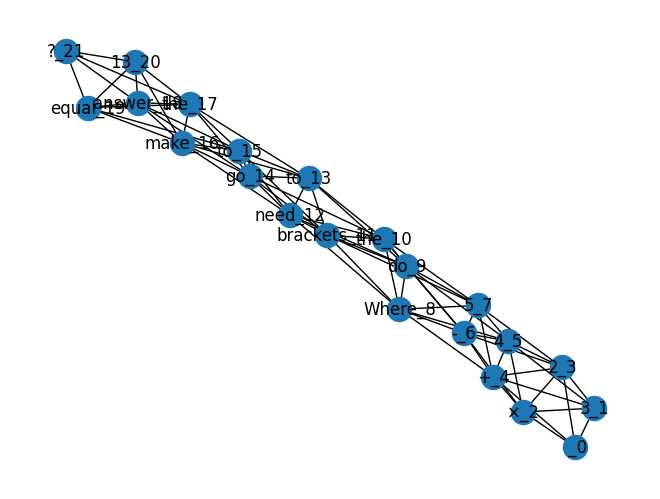

In [ ]:
nx.draw(task_graph,  with_labels = True)

In [ ]:
task_graph.nodes

NodeView((' _0', '3_1', '×_2', '2_3', '+_4', '4_5', '-_6', '5_7', 'Where_8', 'do_9', 'the_10', 'brackets_11', 'need_12', 'to_13', 'go_14', 'to_15', 'make_16', 'the_17', 'answer_18', 'equal_19', '13_20', '?_21'))

In [ ]:
task_graph.edges

EdgeView([(' _0', '3_1'), (' _0', '×_2'), (' _0', '2_3'), (' _0', '+_4'), ('3_1', '×_2'), ('3_1', '2_3'), ('3_1', '+_4'), ('3_1', '4_5'), ('×_2', '2_3'), ('×_2', '+_4'), ('×_2', '4_5'), ('×_2', '-_6'), ('2_3', '+_4'), ('2_3', '4_5'), ('2_3', '-_6'), ('2_3', '5_7'), ('+_4', '4_5'), ('+_4', '-_6'), ('+_4', '5_7'), ('+_4', 'Where_8'), ('4_5', '-_6'), ('4_5', '5_7'), ('4_5', 'Where_8'), ('4_5', 'do_9'), ('-_6', '5_7'), ('-_6', 'Where_8'), ('-_6', 'do_9'), ('-_6', 'the_10'), ('5_7', 'Where_8'), ('5_7', 'do_9'), ('5_7', 'the_10'), ('5_7', 'brackets_11'), ('Where_8', 'do_9'), ('Where_8', 'the_10'), ('Where_8', 'brackets_11'), ('Where_8', 'need_12'), ('do_9', 'the_10'), ('do_9', 'brackets_11'), ('do_9', 'need_12'), ('do_9', 'to_13'), ('the_10', 'brackets_11'), ('the_10', 'need_12'), ('the_10', 'to_13'), ('the_10', 'go_14'), ('brackets_11', 'need_12'), ('brackets_11', 'to_13'), ('brackets_11', 'go_14'), ('brackets_11', 'to_15'), ('need_12', 'to_13'), ('need_12', 'go_14'), ('need_12', 'to_15'), 

In [ ]:
query = train.QuestionText.values[0]
documents = train.QuestionText.values[1:]

ranked_docs = rank_documents(query, documents)
for doc, score in ranked_docs:
    if score > 0.7:
        print(f"{doc} \n SCORE: {score}")
        print('-'*50)

In [ ]:
!pip install py_asciimath

In [ ]:
from py_asciimath.translator.translator import MathML2Tex, Tex2ASCIIMath
import re
import html

mathml2tex = MathML2Tex()
tex2asciimath = Tex2ASCIIMath(log=False, inplace=True)


def mathML_to_ASCIIMath(html_string):
    parsed = mathml2tex.translate(html_string, network=False, from_file=False)
    parsed2 = tex2asciimath.translate(parsed, from_file=False, pprint=False)
    return parsed2


def latex_to_ASCIIMath(latex_string):
    try:
        parsed = tex2asciimath.translate(latex_string.strip('$'), from_file=False, pprint=False)
    except Exception as err:
        print(err)
        parsed = latex_string
    return parsed


def preprocess_html_ents_mathML_Latex_to_ascii_math(text):
    text = html.unescape(text)
    try:
        text = re.sub(r"<math.*</math>", lambda x: mathML_to_ASCIIMath(x.group()), text)
    except Exception as err:
        print(err)
        pass
    try:
        text = re.sub(r"\$.*\$", lambda x: latex_to_ASCIIMath(x.group()), text)
    except Exception as err:
        print(err)
        pass
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+|\\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [ ]:
preprocess_html_ents_mathML_Latex_to_ascii_math(task)

'\\[ 3 \\times 2+4-5 \\] Where do the brackets need to go to make the answer equal \\( 13 \\) ?'

In [ ]:
tex2asciimath.translate(r"\[3 \times 2+4-5\]", from_file=False, pprint=False)

'3 xx 2 + 4 - 5'

In [ ]:
tex2asciimath.translate(r'\frac{3}{4}', from_file=False, pprint=False)

'frac(3)(4)'

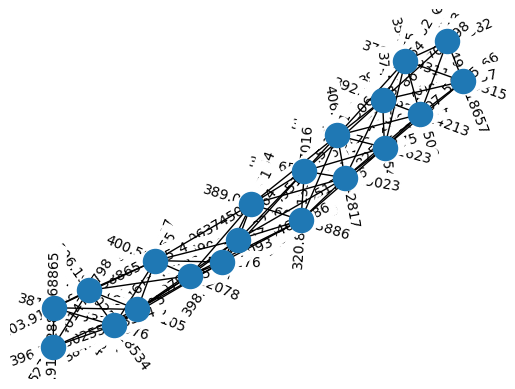

In [ ]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(task_graph)

# Draw nodes and labels
nx.draw_networkx_nodes(task_graph, pos)
nx.draw_networkx_labels(task_graph, pos, labels=nx.get_node_attributes(task_graph, 'label'))

# Draw edges with weights
edge_labels = nx.get_edge_attributes(task_graph, 'weight')
nx.draw_networkx_edge_labels(task_graph, pos, edge_labels=edge_labels)
nx.draw_networkx_edges(task_graph, pos)

# Show graph
plt.axis('off')
plt.show()

In [ ]:
task_graph.nodes

NodeView(('\n_0', '3_1', 'times_2', '245_3', '\n\n_4', 'where_5', 'do_6', 'the_7', 'brackets_8', 'need_9', 'to_10', 'go_11', 'to_12', 'make_13', 'the_14', 'answer_15', 'equal_16', ' _17', '13_18', ' _19'))